# Hubert Stefanski -- 20081102@mail.wit.ie -- Text-Mining -- CA

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import re

plt.style.use("seaborn-darkgrid")

SEED = 666


## Load Dataset and Cleanup

In [2]:
df = pd.read_csv("data/wapo_trumpclaims_export-012021.csv.gz")
print(df.shape)
df.head(2)

(30573, 9)


,id,location,claim,analysis,pinocchios,category,repeated_ids,repeated_count,date
0,31608.0,Remarks,"“We also got tax cuts, the largest tax cut and...","This is Trump’s second favorite falsehood, and...",4.0,Taxes,"31608, 31581, 31305, 31183, 31530, 30920, 3085...",296,01/20/2021
1,31609.0,Remarks,“We just got seventy five million votes. And t...,"When the counting was finished, Trump had rece...",NaN,Election,"31609, 31292, 31155, 31016, 31082, 30992, 3156...",19,01/20/2021


In [3]:
df.category.value_counts(dropna=True)

Immigration            3225
Foreign policy         3165
Election               3037
Miscellaneous          2767
Coronavirus            2521
Trade                  2513
Economy                2475
Russia                 1838
Jobs                   1732
Health care            1629
Ukraine probe          1377
Environment            1065
Biographical record     963
Taxes                   857
Crime                   852
Guns                    165
Education               151
Terrorism                72
Name: category, dtype: int64

In [4]:
# criteria = df.category.isin(["Immigration","Coronavirus"])
df = df.loc[:,["claim","category","location","date"]].copy()

In [5]:
df.category.value_counts()

Immigration            3225
Foreign policy         3165
Election               3037
Miscellaneous          2767
Coronavirus            2521
Trade                  2513
Economy                2475
Russia                 1838
Jobs                   1732
Health care            1629
Ukraine probe          1377
Environment            1065
Biographical record     963
Taxes                   857
Crime                   852
Guns                    165
Education               151
Terrorism                72
Name: category, dtype: int64

In [6]:
def clean_text(text):
    text = re.sub(r"'", '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'pic.twitter\S+', '', text)
    text = re.sub(r'\W+', ' ', text.lower())

    return text

In [7]:
df.dropna(subset=['category'], inplace=True) ## Drop Na from target

print(f"Pre-duplicate drop: {df.shape}") ## Check shape before dropping duplicates

df.drop_duplicates(inplace=True) ## Drop duplicates

print(f"Post-duplicate drop: {df.shape}") ## Check shape after dropping duplicates, if they exist the shape should change

df.drop_duplicates(inplace=True)
df['claim-clean'] = df['claim'].apply(clean_text)
drop_index = []

for i in range(len(df)):
    if df['claim'].iloc[i] in ('', ' '):
        drop_index.append(i)

df.drop(drop_index, inplace=True)

Pre-duplicate drop: (30404, 4)
Post-duplicate drop: (30355, 4)


In [8]:
df.date.str.replace("/","")

0        01202021
1        01202021
2        01202021
3        01202021
4        01202021
           ...   
30568    01202017
30569    01202017
30570    01202017
30571    01202017
30572    01202017
Name: date, Length: 30355, dtype: object

In [9]:
df.location.value_counts(dropna=False)

Campaign rally       9479
Remarks              6205
Interview            4969
Twitter              4694
Speech               2763
News conference      1894
Vlog                  148
Statement             123
Leaked transcript      80
Name: location, dtype: int64

In [10]:
# sns.histplot(x='date',data=df) // COMMENTED OUT DUE TO VERSION ISSUE

## Feature Engineering

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1, 2), min_df=2)
X_tfidf = tfidf.fit_transform(df['claim-clean'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df.category, test_size=0.4, stratify = df.category ,random_state=SEED)

# (X_train.shape,y_train.shape,X_test.shape,y_test.shape)

In [13]:
# df_train, df_test = train_test_split(df, test_size=0.4, stratify = df.category ,random_state=SEED)

In [14]:
# from sklearn.feature_extraction.text import CountVectorizer
# count_vectorizer = CountVectorizer(stop_words="english",ngram_range=(1,2),lowercase=True)

In [15]:
# X_train_counts = count_vectorizer.fit_transform(X_train)
# X_test_counts = count_vectorizer.transform(X_test)

# X_test_counts.shape

In [16]:
# print(list(count_vectorizer.get_feature_names()[:100]))

In [17]:
# from sklearn.feature_extraction.text import TfidfTransformer
# tf = TfidfTransformer()

# X_tftrain = tf.fit_transform(X_train_counts)

## Model Building

In [26]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='entropy', max_depth=4)
svc = SVC(gamma="scale",probability=True)
mnb = MultinomialNB()
lgr = LogisticRegression(max_iter=1000,solver='saga',random_state=SEED, C=20, n_jobs=-1)
voting = VotingClassifier(estimators=[('logReg', lgr),('DecisionTree', dt), ('SVC', svc), ('MultiBiNom', mnb)],
                           voting='soft', n_jobs=-1)

models = [
#           dt, ## ABSOLUTELY USELESS <13%
#           sv, ## COMMENT THIS OUT IF YOU LIKE WASTING YOUR TIME
#           mnb,
          lgr,
#           voting
         ]


In [27]:
for model in models:
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(f"-------------{model}------------------------------------------")
    print(classification_report(y_test,y_pred,zero_division=True,digits=4))
    



-------------LogisticRegression(C=20, max_iter=1000, n_jobs=-1, random_state=666)------------------------------------------
                     precision    recall  f1-score   support

Biographical record     0.6902    0.5325    0.6012       385
        Coronavirus     0.8626    0.8661    0.8644      1008
              Crime     0.7838    0.5971    0.6778       340
            Economy     0.8034    0.8059    0.8046       989
          Education     1.0000    0.8103    0.8952        58
           Election     0.7569    0.7949    0.7754      1214
        Environment     0.9116    0.7746    0.8376       426
     Foreign policy     0.8351    0.8688    0.8516      1265
               Guns     0.9038    0.7121    0.7966        66
        Health care     0.8850    0.8673    0.8761       648
        Immigration     0.8801    0.9184    0.8989      1287
               Jobs     0.8526    0.8538    0.8532       691
      Miscellaneous     0.5295    0.6320    0.5763      1106
             Russia  

In [20]:
print(classification_report(y_test,y_pred,zero_division=True,digits=4))

                     precision    recall  f1-score   support

Biographical record     0.6902    0.5325    0.6012       385
        Coronavirus     0.8634    0.8651    0.8642      1008
              Crime     0.7846    0.6000    0.6800       340
            Economy     0.8036    0.8069    0.8052       989
          Education     1.0000    0.8103    0.8952        58
           Election     0.7581    0.7949    0.7760      1214
        Environment     0.9116    0.7746    0.8376       426
     Foreign policy     0.8345    0.8688    0.8513      1265
               Guns     0.9038    0.7121    0.7966        66
        Health care     0.8850    0.8673    0.8761       648
        Immigration     0.8801    0.9184    0.8989      1287
               Jobs     0.8526    0.8538    0.8532       691
      Miscellaneous     0.5295    0.6320    0.5763      1106
             Russia     0.8739    0.8299    0.8514       735
              Taxes     0.9205    0.8801    0.8999       342
          Terrorism    

In [21]:
df_cm = pd.crosstab(y_test,y_pred)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
df_cm

Predicted,Biographical record,Coronavirus,Crime,Economy,Education,Election,Environment,Foreign policy,Guns,Health care,Immigration,Jobs,Miscellaneous,Russia,Taxes,Terrorism,Trade,Ukraine probe
Actual,,,,,,,,,,,,,,,,,,
Biographical record,205,5,0,12,0,35,2,13,0,4,7,1,84,3,2,0,8,4
Coronavirus,3,872,0,20,0,18,1,21,0,2,13,2,48,1,0,0,4,3
Crime,2,6,204,5,0,22,0,7,0,2,33,1,51,5,0,0,1,1
Economy,6,16,1,798,0,7,11,17,1,2,6,57,39,1,9,0,18,0
Education,0,0,0,0,47,1,0,2,0,0,2,0,6,0,0,0,0,0
Election,21,15,17,8,0,965,0,11,1,1,9,1,118,18,7,0,1,21
Environment,1,10,0,7,0,6,330,10,0,1,4,10,31,1,0,0,14,1
Foreign policy,1,22,2,16,0,19,0,1099,0,1,14,1,55,12,0,0,19,4
Guns,0,4,0,2,0,7,0,1,47,0,2,0,3,0,0,0,0,0


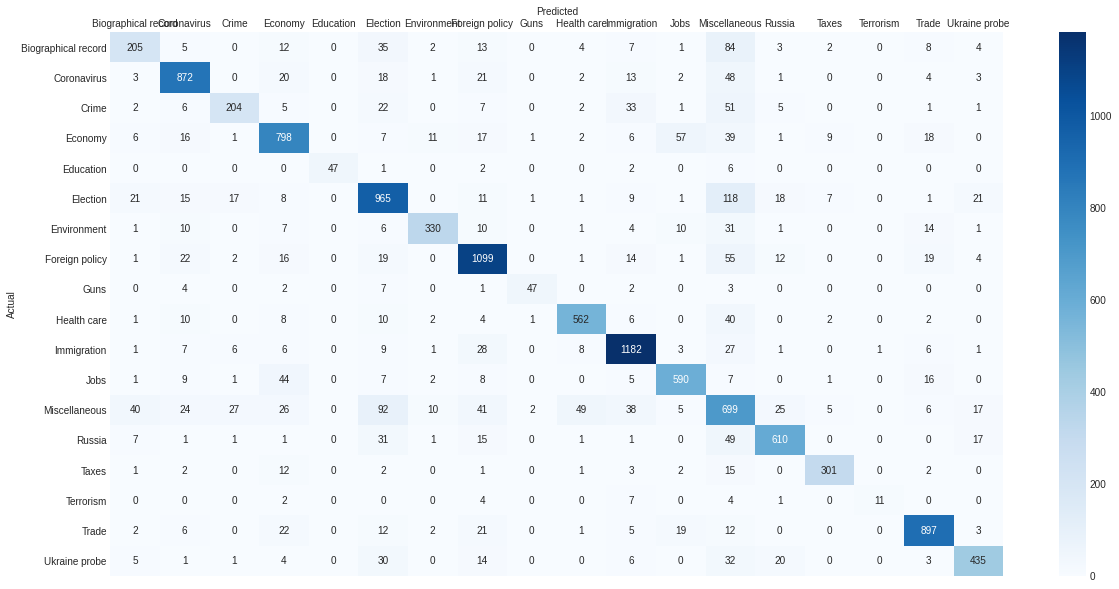

In [22]:
plt.figure(figsize=(20,10))
g = sns.heatmap(df_cm,annot=True,fmt="d",cmap="Blues")
g.xaxis.set_ticks_position('top')
g.xaxis.set_label_position('top')

In [23]:
print(classification_report(y_test, y_pred, zero_division=0, digits=4))

                     precision    recall  f1-score   support

Biographical record     0.6902    0.5325    0.6012       385
        Coronavirus     0.8634    0.8651    0.8642      1008
              Crime     0.7846    0.6000    0.6800       340
            Economy     0.8036    0.8069    0.8052       989
          Education     1.0000    0.8103    0.8952        58
           Election     0.7581    0.7949    0.7760      1214
        Environment     0.9116    0.7746    0.8376       426
     Foreign policy     0.8345    0.8688    0.8513      1265
               Guns     0.9038    0.7121    0.7966        66
        Health care     0.8850    0.8673    0.8761       648
        Immigration     0.8801    0.9184    0.8989      1287
               Jobs     0.8526    0.8538    0.8532       691
      Miscellaneous     0.5295    0.6320    0.5763      1106
             Russia     0.8739    0.8299    0.8514       735
              Taxes     0.9205    0.8801    0.8999       342
          Terrorism    